In [14]:
import os
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import warnings
import os
import random
import glob
import nibabel as nib
import numpy as np
from scipy.ndimage import rotate
import csv
import SimpleITK as sitk
#from lungtumormask import mask as tumormask
#from lungmask import mask as lungmask_fun
#from skimage.measure import label, regionprops,shannon_entropy
#from skimage.morphology import dilation,ball,erosion,remove_small_objects

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChannel,
    EnsureChannelFirst,
    ResizeWithPadOrCropd,
    MapTransform,
    MaskIntensityd,
    ScaleIntensityd,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    ResizeWithPadOrCrop,
    LoadImaged,
    Orientationd,
    ThresholdIntensity,
    KeepLargestConnectedComponent,
    RandCropByPosNegLabeld,
    SaveImaged,
    CenterSpatialCropd,
    SpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    AsDiscrete,
    SpatialCrop,
    SpatialPadd,
    EnsureTyped,
    EnsureType,
    DivisiblePadd,
    ToTensord,
    Transpose,
    ScaleIntensity,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch,pad_list_data_collate
from skimage.measure import label, regionprops,shannon_entropy
from skimage.morphology import dilation,ball,erosion,remove_small_objects

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

if True:
    get_ipython().run_line_magic('matplotlib', 'inline')
    print('plot in line')

device: cuda
plot in line


In [16]:
# class to transpose lung mask
class Create_sequences(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        print(f"keys to transpose: {self.keys}")

    def __call__(self, dictionary):
        dictionary = dict(dictionary)
        for key in self.keys:
            data = dictionary[key]
            if key == 'lung':
                data = np.transpose(data, (0, 2, 3, 1))
                data = rotate(data, 270, axes=(1, 2), reshape=False)
                data = np.flip(data, 1)
                data[data == 2] = int(1)
                data[data != 1] = int(0)
            dictionary[key] = data

        return dictionary


In [17]:
root_path = '/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti_AllBP_V2/'
figures_path = '/home/umcg/Desktop/AutomaticITV_code/figures_folder_i/'
figures_folder_i = figures_path+'figures_SwinDyn_V11_ITV'
average_folder_path = '/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti_Averages_CT/'
gtv_folder_path = '/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti_GTVlabels/'

In [18]:
# HU are -1000 air , 0 water , usually normal tissue are around 0, top values should be around 100, bones are around 1000
minmin_CT = -1024
maxmax_CT = 200 
#Create Compose functions for preprocessing of train and validation
image_keys = ["GTV_no"]
size = 96
image_size = (size,size,size)
multiplier = 2
val_transforms = Compose(
    [
        LoadImaged(keys=image_keys),
        #EnsureChannelFirstd(keys=["image","lung","ITV","GTV_label"]),
        Orientationd(keys=image_keys, axcodes="RAS"),
        #Spacingd(keys=["image","label"], pixdim=(1,1,1),mode=("bilinear","nearest")),
        #ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        #Create_sequences(keys=["image","ITV","lung","GTV_label"]),
        CropForegroundd(keys=image_keys, source_key="GTV_no",k_divisible = size),
        ResizeWithPadOrCropd(keys=image_keys,spatial_size=(384, 384, 192), method="symmetric"),
        #MaskIntensityd(keys=["image"], mask_key="lung"),
        CropForegroundd(keys=image_keys, source_key="GTV_no",k_divisible = size*multiplier),
        AsDiscreted(keys=["GTV_no"],to_onehot=None,threshold=.01),
        ToTensord(keys=image_keys),
    ]
)


In [19]:
def LookSortFiles(root_path, all_patientdir):
    CTALL_fpaths =[]
    lungALL_fpaths =[]
    itv_fpaths = []
    gtv_fpaths = []  
    gtvNo_fpaths = []
    predicted_fpaths_no = []
    average_path = []
    for patient_path in all_patientdir:
        average_miss = 0
        for root, dirs, files in os.walk(average_folder_path + patient_path, topdown=False):
            for f in files:
                if 'ave' in f.lower():
                    average_miss+=1
                    average_path.append(os.path.join(average_folder_path, patient_path, f))
    for patient_path in all_patientdir:
        gtv_miss = 0
        for root, dirs, files in os.walk(gtv_folder_path + patient_path, topdown=False):
            for f in files:
                if 'gtv' in f.lower():
                    gtv_miss+=1
                    gtv_fpaths.append(os.path.join(gtv_folder_path, patient_path, f))
    
    for patient_path in all_patientdir:
        ct_miss = 0
        gtvNo_miss =0
        itv_miss = 0
        lung_miss = 0
        predicted_miss_no =0
        print(patient_path)
        for root, dirs, files in os.walk(root_path + patient_path, topdown=False):
            for f in files:
                if "predicteditv_allbp_no" in f.lower():
                    predicted_fpaths_no.append(os.path.join(root_path, patient_path, f))
                    predicted_miss_no+=1
                if "gtv" in f.lower() and "bp" in f.lower() and "no" in f.lower():
                    gtvNo_fpaths.append(os.path.join(root_path, patient_path, f))
                    gtvNo_miss +=1
                if "pproved" in f.lower():
                    itv_fpaths.append(os.path.join(root_path, patient_path, f))
                    itv_miss +=1
                if "50%" in f.lower() and not("ave" in f.lower()):
                    if "ct" in f.lower():                            
                        CTALL_fpaths.append(os.path.join(root_path, patient_path, f))
                        ct_miss +=1
                    if "lung" in f.lower():
                        lungALL_fpaths.append(os.path.join(root_path, patient_path, f))
                        lung_miss +=1

    print('ct: ',ct_miss,"gtv",gtv_miss,"Lungs: ",lung_miss, "ITVLabel: ",itv_miss,"pITV no",predicted_miss_no,"Ave",average_miss,"GTV No",gtvNo_miss)
    gtvNo_fpaths = np.sort(gtvNo_fpaths)
    if gtv_miss ==0 :
        print("No GTV, will show ITV twice instead")
        return average_path, itv_fpaths,itv_fpaths, lungALL_fpaths,predicted_fpaths_no,gtvNo_fpaths
    else:
        return average_path, itv_fpaths,gtv_fpaths, lungALL_fpaths,predicted_fpaths_no,gtvNo_fpaths

In [20]:
def LoadDataSet(val_files,val_transforms):
    #Check the images after the preprocessing
    check_ds =Dataset(data=val_files, transform=val_transforms)
    check_loader = DataLoader(check_ds, batch_size=1,num_workers=0)    
    val_inputs = [] 
    for batch_data in check_loader:
        val_inputs.append(batch_data["GTV_no"].to(device))
    return val_inputs


In [21]:
def plotContours(val_inputs):
    figsize = (18, 9)
    colorsL = ["red","blue","green","gray","black","yellow","cyan","pink","olive"]
    fig = plt.figure('Instance = {}'.format(0), figsize=figsize)          
    ax = fig.add_subplot(111)
    for i in range(len(val_inputs)):   
        for k in range(val_inputs[i].shape[-1]):
            if np.sum(val_inputs[i][:,:,k])>0:
                ax.contour(np.rot90(np.squeeze(val_inputs[i][:,:, k])),colors=colorsL[i])
    plt.tight_layout(),plt.show()
    return 0 

In [34]:
def TumorTrajectory(predicted_ITV_interp):
    xx = np.zeros(len(predicted_ITV_interp),int)
    yy = np.zeros(len(predicted_ITV_interp),int)
    zz = np.zeros(len(predicted_ITV_interp),int)
    for l in range(len(predicted_ITV_interp)):
        labeledGTV = label(predicted_ITV_interp[l].detach().cpu().numpy().squeeze())
        propsGTV = regionprops(labeledGTV)
        for m in range(len(propsGTV)):
            print("GTV #",l," -Centroid: ",propsGTV[m].centroid)
            xx[l],yy[l],zz[l] = propsGTV[m].centroid
            break
    ax = plt.figure().add_subplot(projection='3d')
    plt.subplot(1,1,1),plt.plot(xx,yy,zz,label='x,y,z')
    ax.legend()
    plt.show()
    plt.subplot(1,3,1),plt.plot(xx)
    plt.subplot(1,3,2),plt.plot(yy)
    plt.subplot(1,3,3),plt.plot(zz)
    plt.show()
    print('Limits: ',xx.max()-xx.min(),yy.max()-yy.min(),zz.max()-zz.min())
    
    return xx.max()-xx.min(),yy.max()-yy.min(),zz.max()-zz.min()


4933165/
ct:  1 gtv 1 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
CT val len: 9


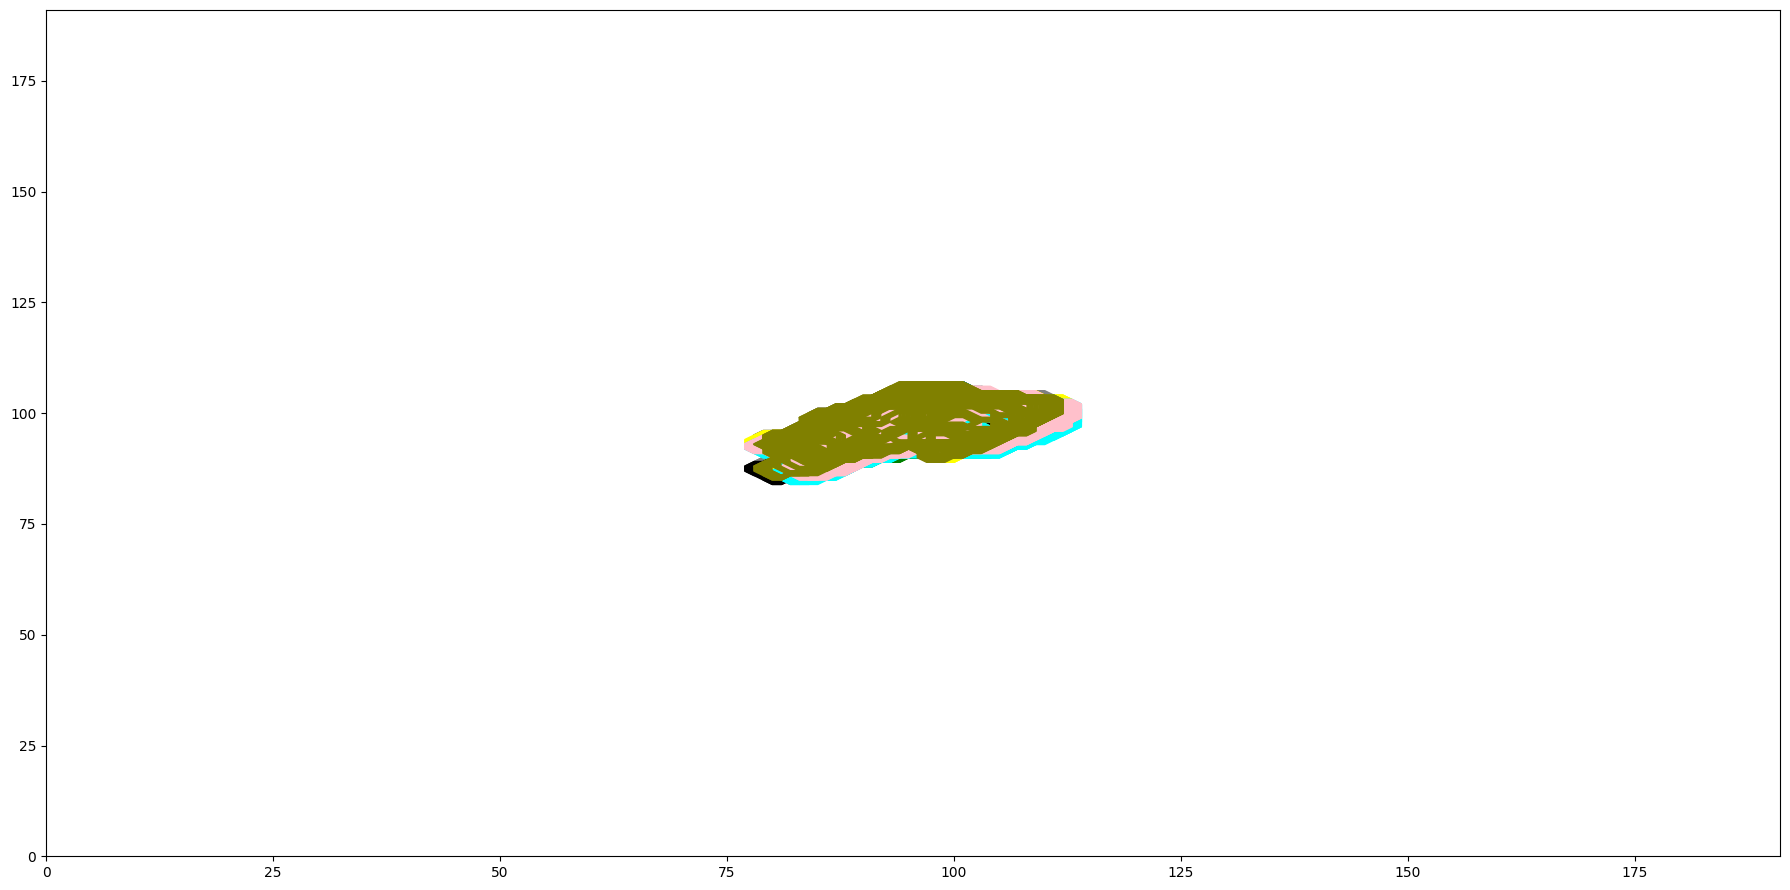

GTV # 0  -Centroid:  (93.26966546112116, 96.09154611211574, 94.27396021699819)
GTV # 1  -Centroid:  (92.87030557499416, 96.53277350128295, 93.72754840214603)
GTV # 2  -Centroid:  (93.39423304183408, 95.54951548097377, 95.18458993145829)
GTV # 3  -Centroid:  (93.1537260151718, 94.99576082106202, 93.82842481035252)
GTV # 4  -Centroid:  (92.99251361161525, 95.77019056261344, 94.21551724137932)
GTV # 5  -Centroid:  (92.55116772823779, 95.5936305732484, 94.45350318471337)
GTV # 6  -Centroid:  (92.4077791718946, 96.29109159347553, 95.05478879130071)
GTV # 7  -Centroid:  (92.77331577792407, 96.14680710994075, 94.50954575378539)
GTV # 8  -Centroid:  (93.29204339963833, 94.86528028933093, 93.72784810126582)


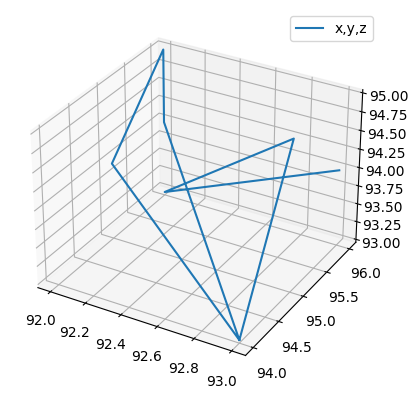

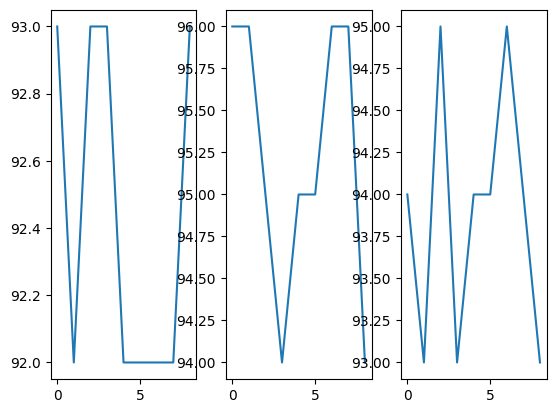

Limits:  1 2 2
2038375/
ct:  1 gtv 1 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
CT val len: 9


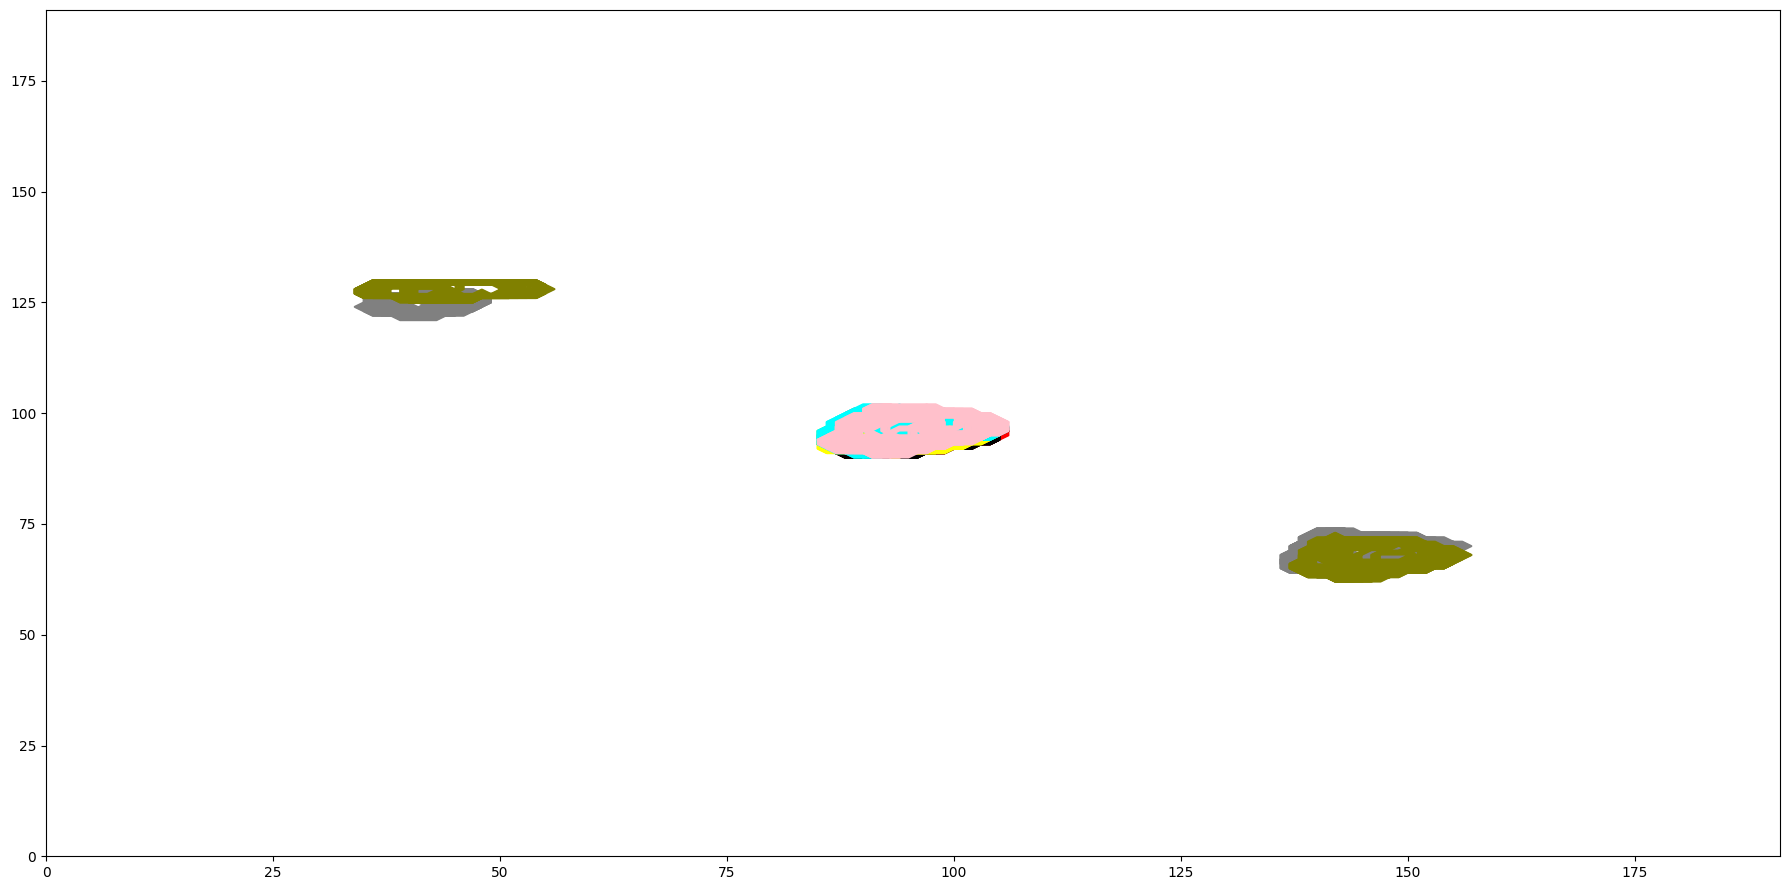

GTV # 0  -Centroid:  (94.58953951108585, 95.20181921546333, 95.78567367822626)
GTV # 1  -Centroid:  (95.23504867872045, 94.46105702364395, 95.25591098748261)
GTV # 2  -Centroid:  (94.87138461538461, 94.7236923076923, 95.59138461538461)
GTV # 3  -Centroid:  (73.04469273743017, 41.935754189944134, 66.06983240223464)
GTV # 4  -Centroid:  (94.93095512082854, 95.1150747986191, 95.67491369390103)
GTV # 5  -Centroid:  (95.52461227242077, 94.21982467970331, 95.92447741065408)
GTV # 6  -Centroid:  (94.64123471170646, 94.66802562609202, 94.84274898078043)
GTV # 7  -Centroid:  (94.97822141560799, 95.47549909255898, 94.85178463399879)
GTV # 8  -Centroid:  (74.58557284299859, 44.15417256011315, 63.193776520509196)


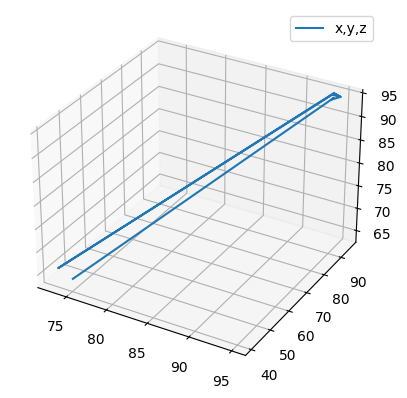

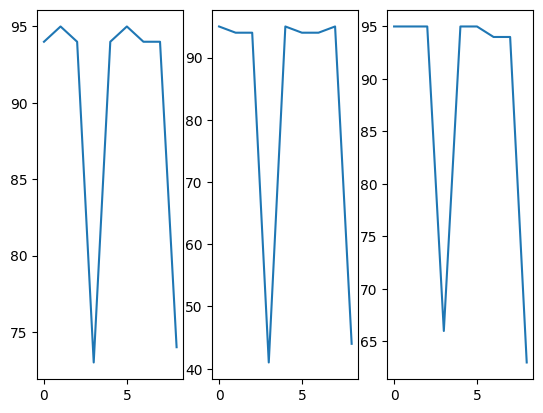

Limits:  22 54 32
8643781/
ct:  1 gtv 1 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
CT val len: 9


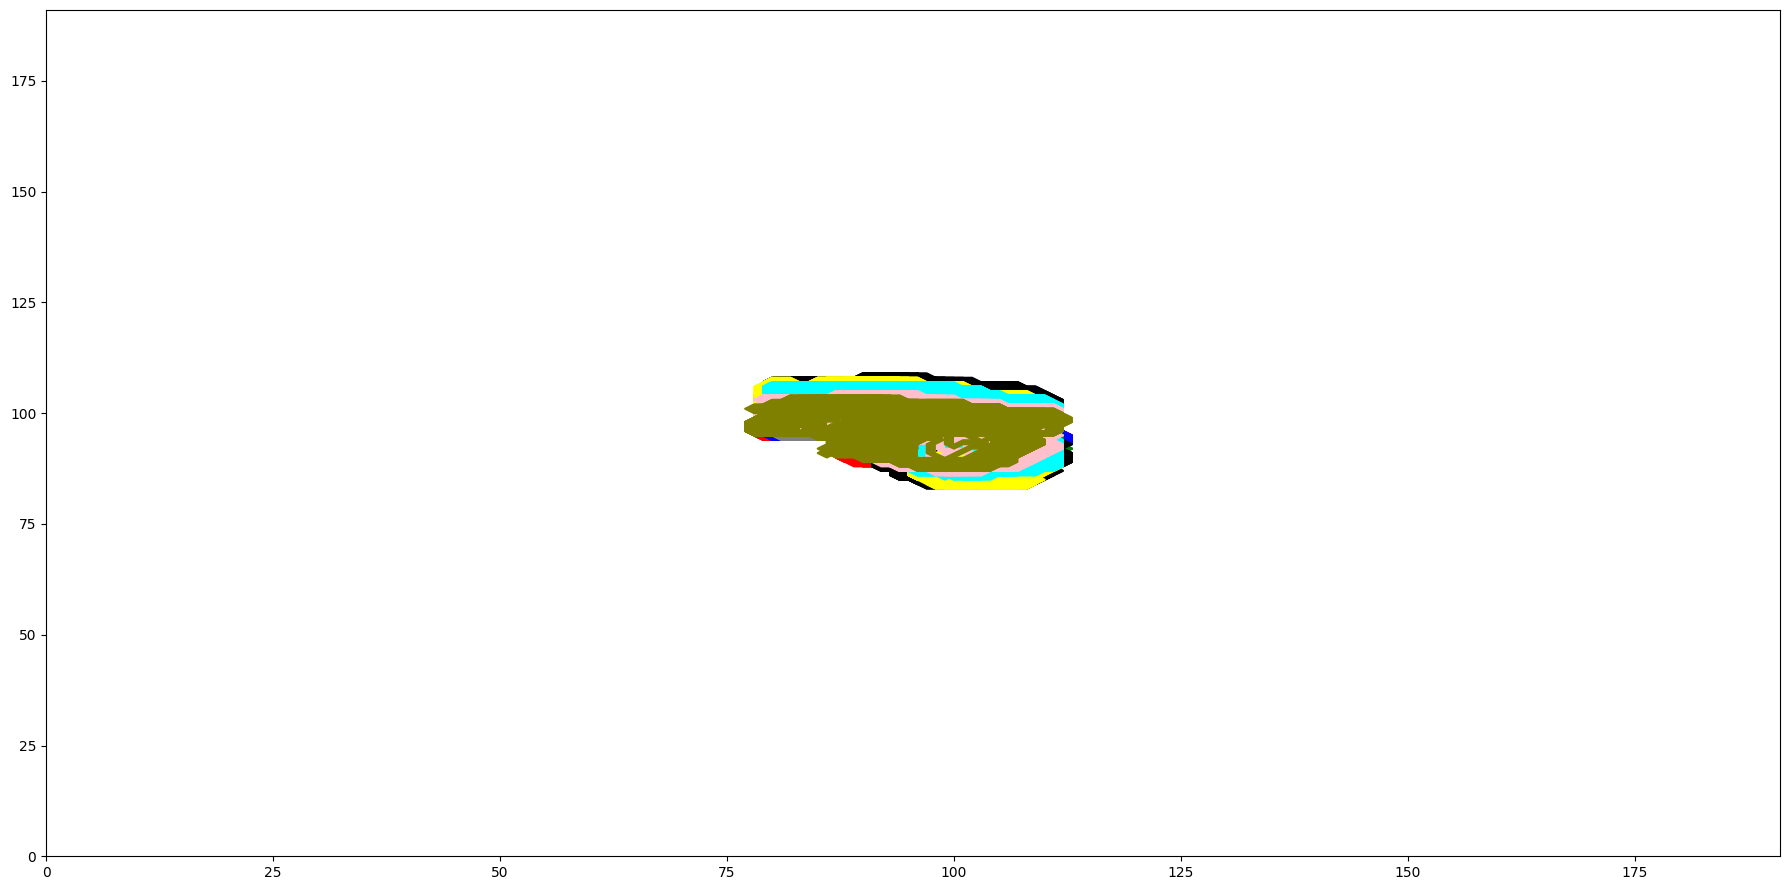

GTV # 0  -Centroid:  (41.74801843317972, 92.35612903225807, 93.68129032258065)
GTV # 1  -Centroid:  (41.52215040201797, 92.13778968942141, 92.2265489516002)
GTV # 2  -Centroid:  (43.672326481977954, 92.32901400059578, 90.70539171879655)
GTV # 3  -Centroid:  (43.625247664874045, 90.94551372771016, 90.32153976790264)
GTV # 4  -Centroid:  (43.773435326842836, 91.984561891516, 88.69694019471488)
GTV # 5  -Centroid:  (44.53562447611065, 91.28918692372172, 89.38376641519977)
GTV # 6  -Centroid:  (42.48710518690235, 92.01579252390611, 89.68545349174153)
GTV # 7  -Centroid:  (42.46634615384615, 91.7912798408488, 91.58521220159152)
GTV # 8  -Centroid:  (41.12595281306715, 91.50689655172414, 92.6377495462795)


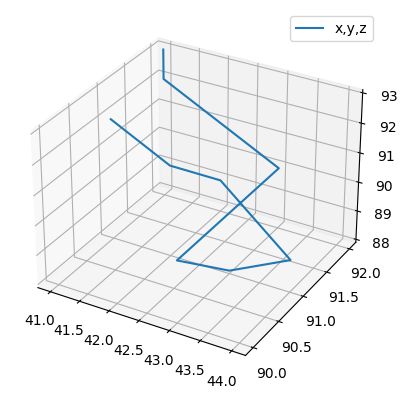

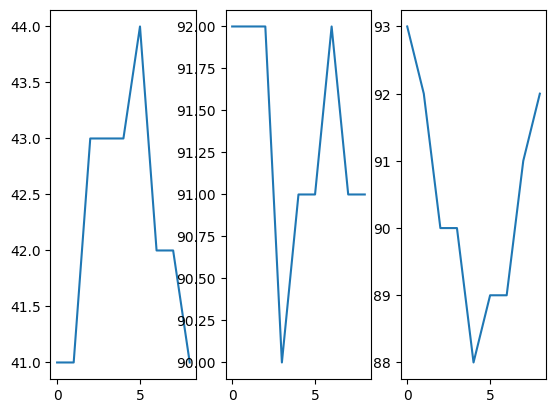

Limits:  3 2 5
5655827/
ct:  1 gtv 0 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
No GTV, will show ITV twice instead
CT val len: 9


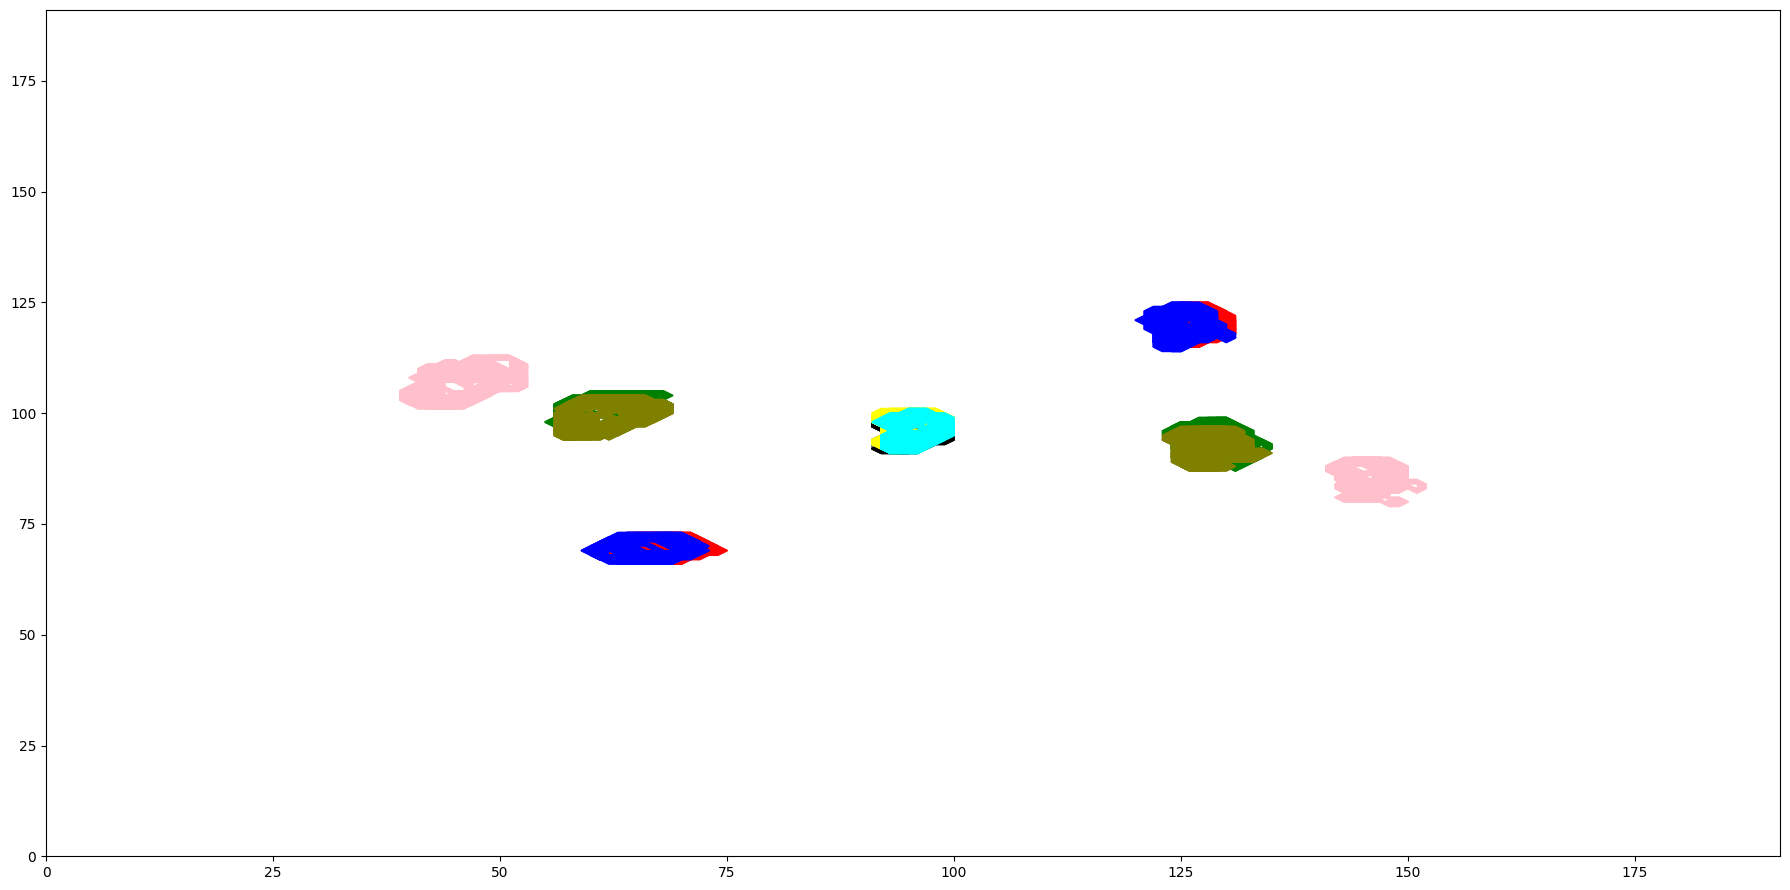

GTV # 0  -Centroid:  (47.015544041450774, 66.83160621761658, 121.59326424870466)
GTV # 1  -Centroid:  (47.016260162601625, 65.84823848238483, 121.55555555555556)
GTV # 2  -Centroid:  (41.631276901004306, 61.753228120516496, 90.32855093256815)
GTV # 3  -Centroid:  (93.7536231884058, 94.80869565217391, 95.37101449275362)
GTV # 4  -Centroid:  (94.5788043478261, 95.3695652173913, 95.3586956521739)
GTV # 5  -Centroid:  (93.68717948717949, 95.13076923076923, 94.5974358974359)
GTV # 6  -Centroid:  (93.50306748466258, 95.57361963190183, 95.19938650306749)
GTV # 7  -Centroid:  (83.99344262295082, 145.60983606557377, 105.39344262295081)
GTV # 8  -Centroid:  (41.37849162011173, 61.94832402234637, 91.33659217877096)


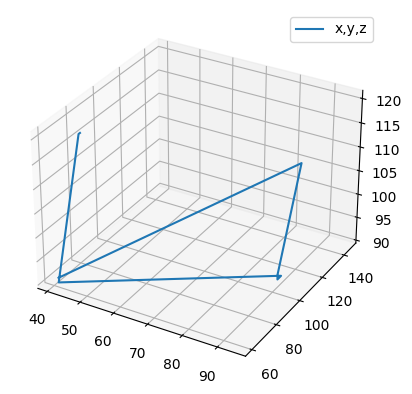

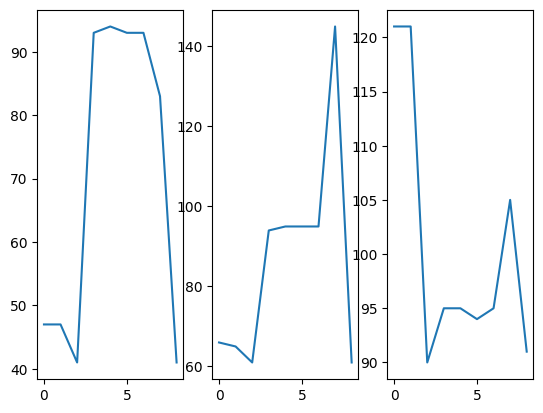

Limits:  53 84 31
5836741/
ct:  1 gtv 0 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
No GTV, will show ITV twice instead
CT val len: 9


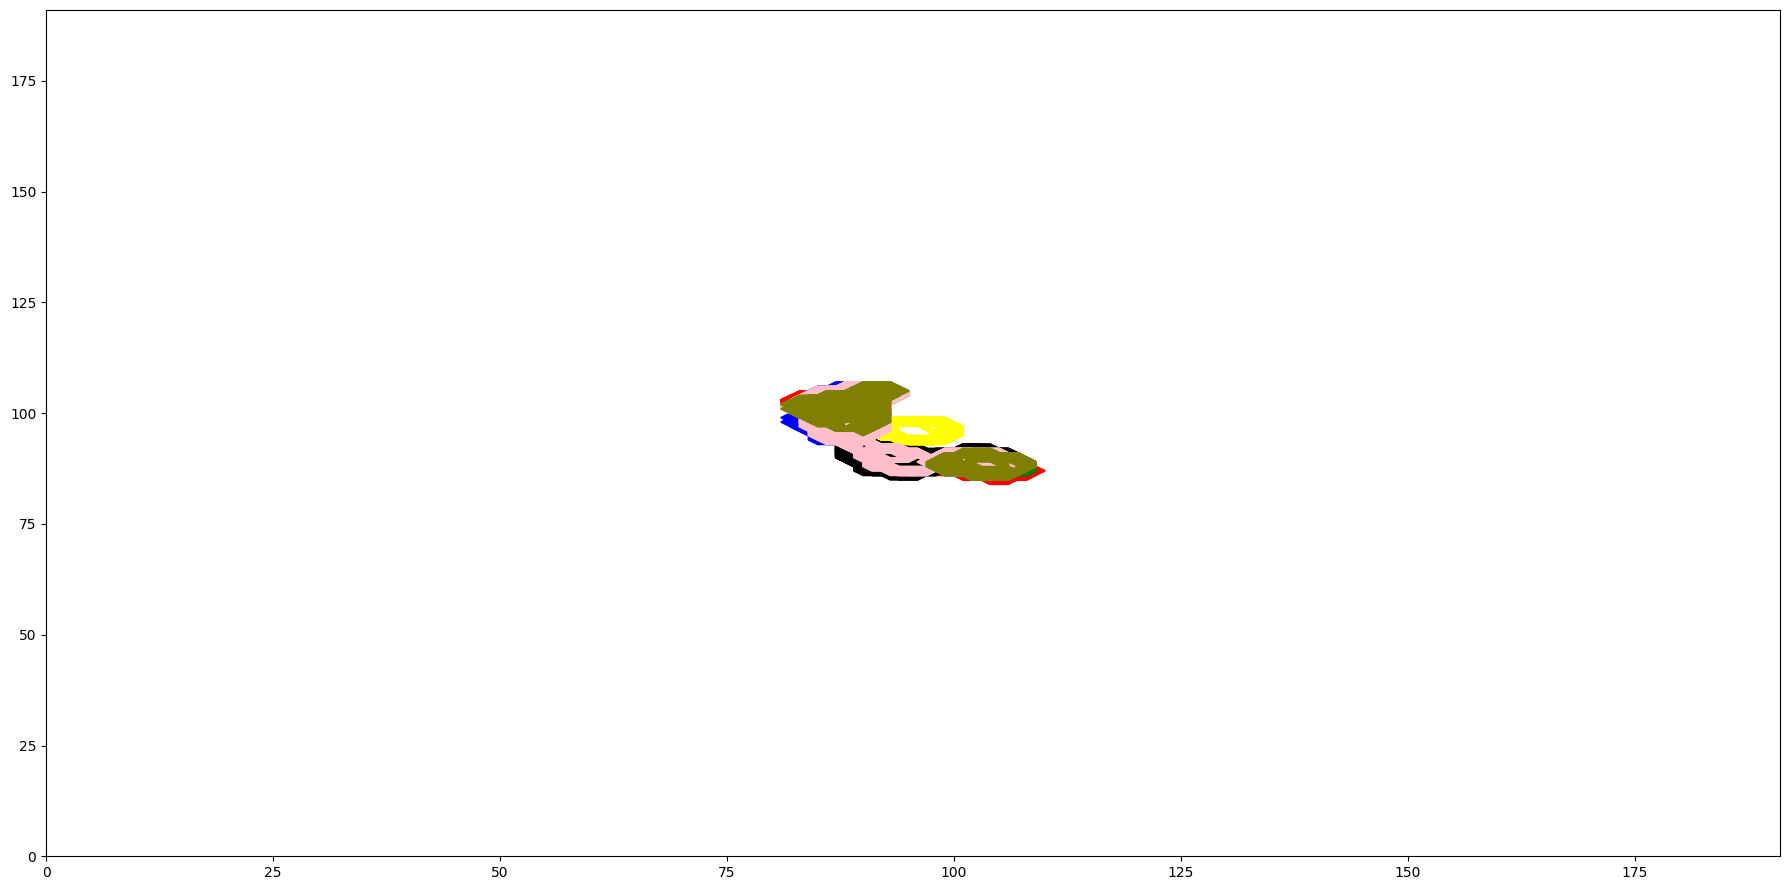

GTV # 0  -Centroid:  (89.02597402597402, 103.72077922077922, 103.2012987012987)
GTV # 1  -Centroid:  (94.4037037037037, 87.80987654320988, 90.32962962962964)
GTV # 2  -Centroid:  (89.26277372262774, 103.6094890510949, 102.91970802919708)
GTV # 3  -Centroid:  (89.01230769230769, 102.43692307692308, 102.29538461538462)
GTV # 4  -Centroid:  (92.12888198757764, 93.70419254658385, 97.16614906832298)
GTV # 5  -Centroid:  (94.98239436619718, 95.73239436619718, 94.83802816901408)
GTV # 6  -Centroid:  (90.25316455696202, 102.50632911392405, 102.62447257383967)
GTV # 7  -Centroid:  (93.62131837307153, 92.00561009817672, 94.24544179523141)
GTV # 8  -Centroid:  (88.65894039735099, 103.1887417218543, 102.63245033112582)


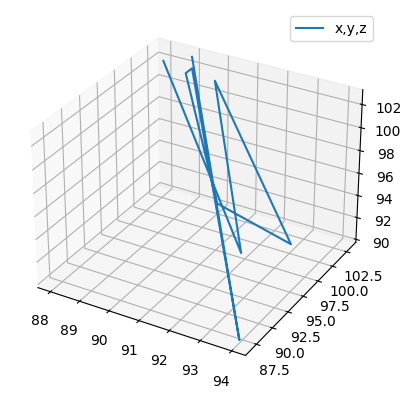

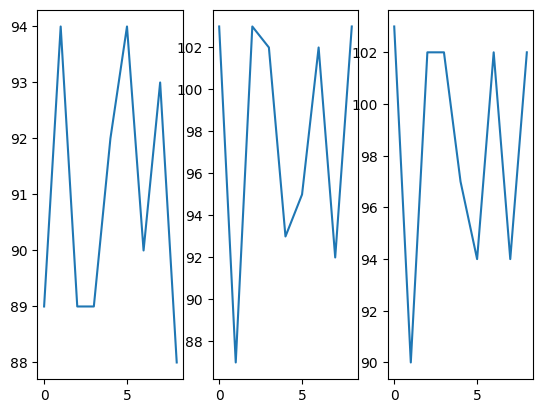

Limits:  6 16 13
0070683/
ct:  1 gtv 1 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
CT val len: 9


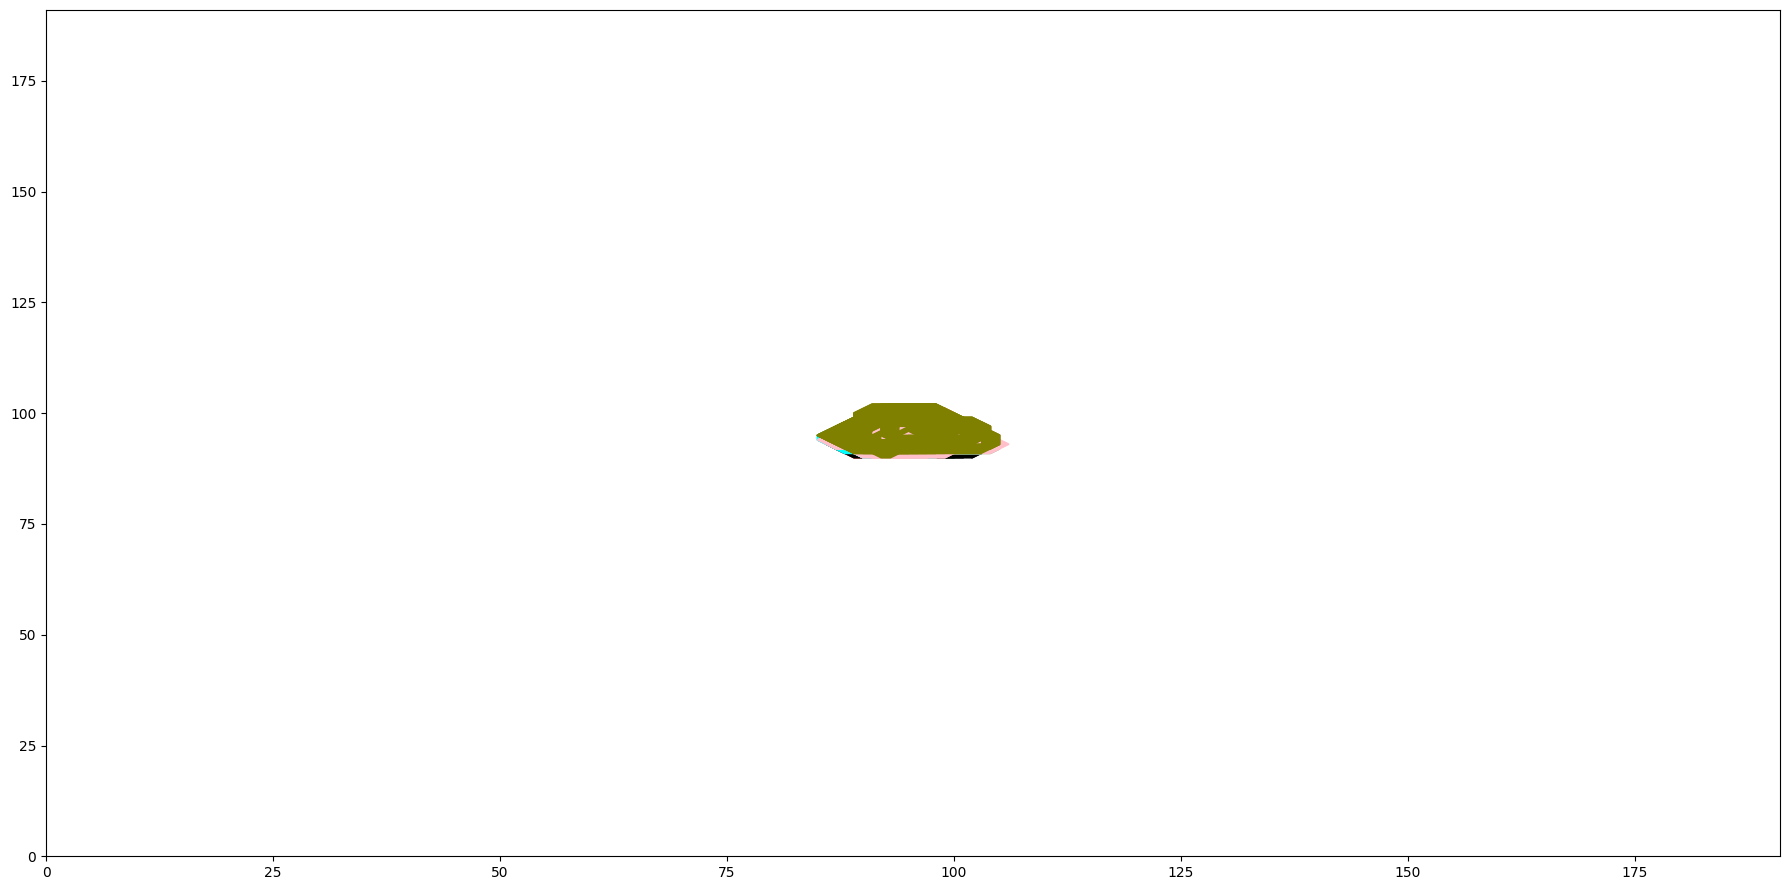

GTV # 0  -Centroid:  (95.27506775067751, 94.81639566395664, 95.65921409214093)
GTV # 1  -Centroid:  (95.65562913907284, 95.33259749816041, 95.86754966887418)
GTV # 2  -Centroid:  (95.15965834428384, 95.1622864651774, 95.72141918528253)
GTV # 3  -Centroid:  (95.25786646201074, 95.18726016884114, 95.96546431312356)
GTV # 4  -Centroid:  (95.18195050946143, 95.01819505094615, 96.39374090247453)
GTV # 5  -Centroid:  (95.41268758526603, 95.26944065484311, 95.65484311050477)
GTV # 6  -Centroid:  (94.47857613711273, 94.90112063282795, 95.81740276862229)
GTV # 7  -Centroid:  (95.59339263024142, 95.50317662007623, 95.8271918678526)
GTV # 8  -Centroid:  (95.50369948776323, 94.91064314171884, 94.90779738190096)


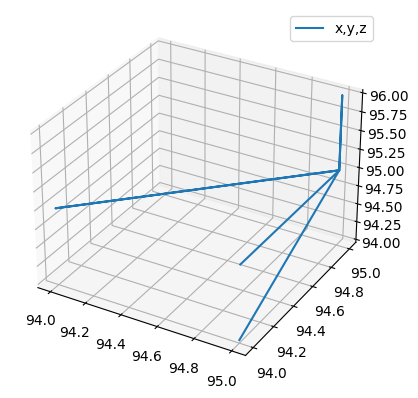

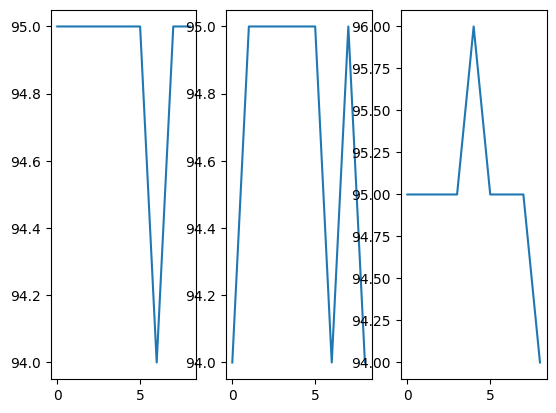

Limits:  1 1 2
1726691/
ct:  1 gtv 1 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
CT val len: 9


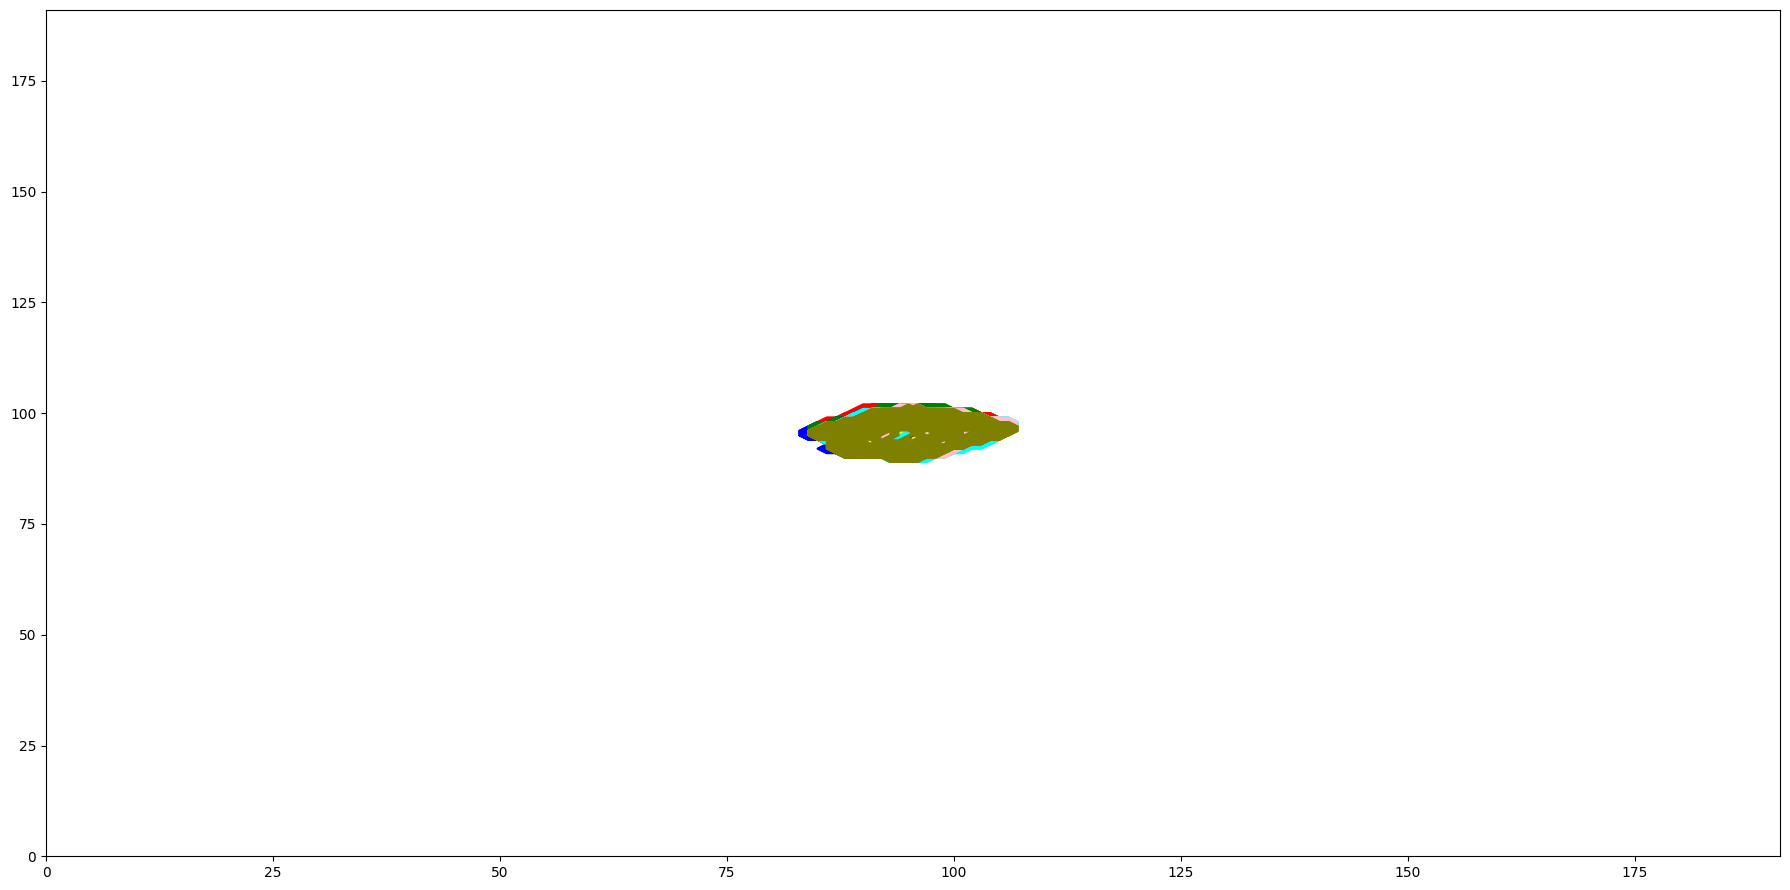

GTV # 0  -Centroid:  (94.8229895104895, 94.81861888111888, 94.97858391608392)
GTV # 1  -Centroid:  (94.24418604651163, 94.0, 95.60286225402504)
GTV # 2  -Centroid:  (94.9263862332696, 94.76864244741874, 94.99521988527725)
GTV # 3  -Centroid:  (94.5401096163428, 94.79521674140508, 95.29596412556054)
GTV # 4  -Centroid:  (94.27215189873418, 94.73271665043816, 95.6066212268744)
GTV # 5  -Centroid:  (95.1655034895314, 95.43718843469591, 95.62163509471586)
GTV # 6  -Centroid:  (95.0501745200698, 95.25959860383944, 95.71596858638743)
GTV # 7  -Centroid:  (93.96189164370982, 95.2516069788797, 95.51790633608816)
GTV # 8  -Centroid:  (94.76621621621622, 94.93153153153153, 95.73738738738739)


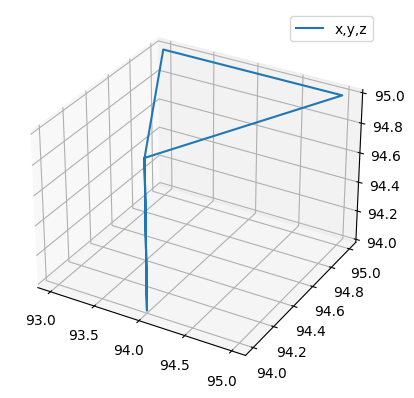

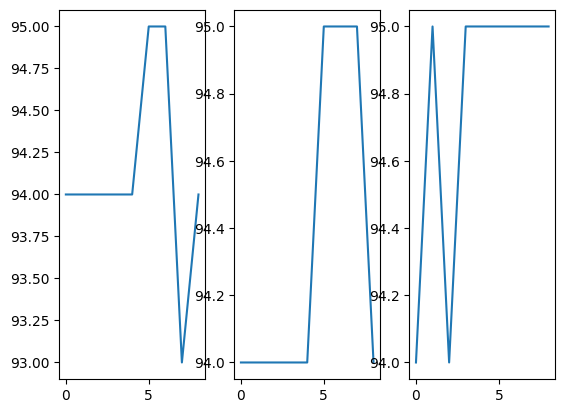

Limits:  2 1 1
4660898/
ct:  1 gtv 1 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
CT val len: 9


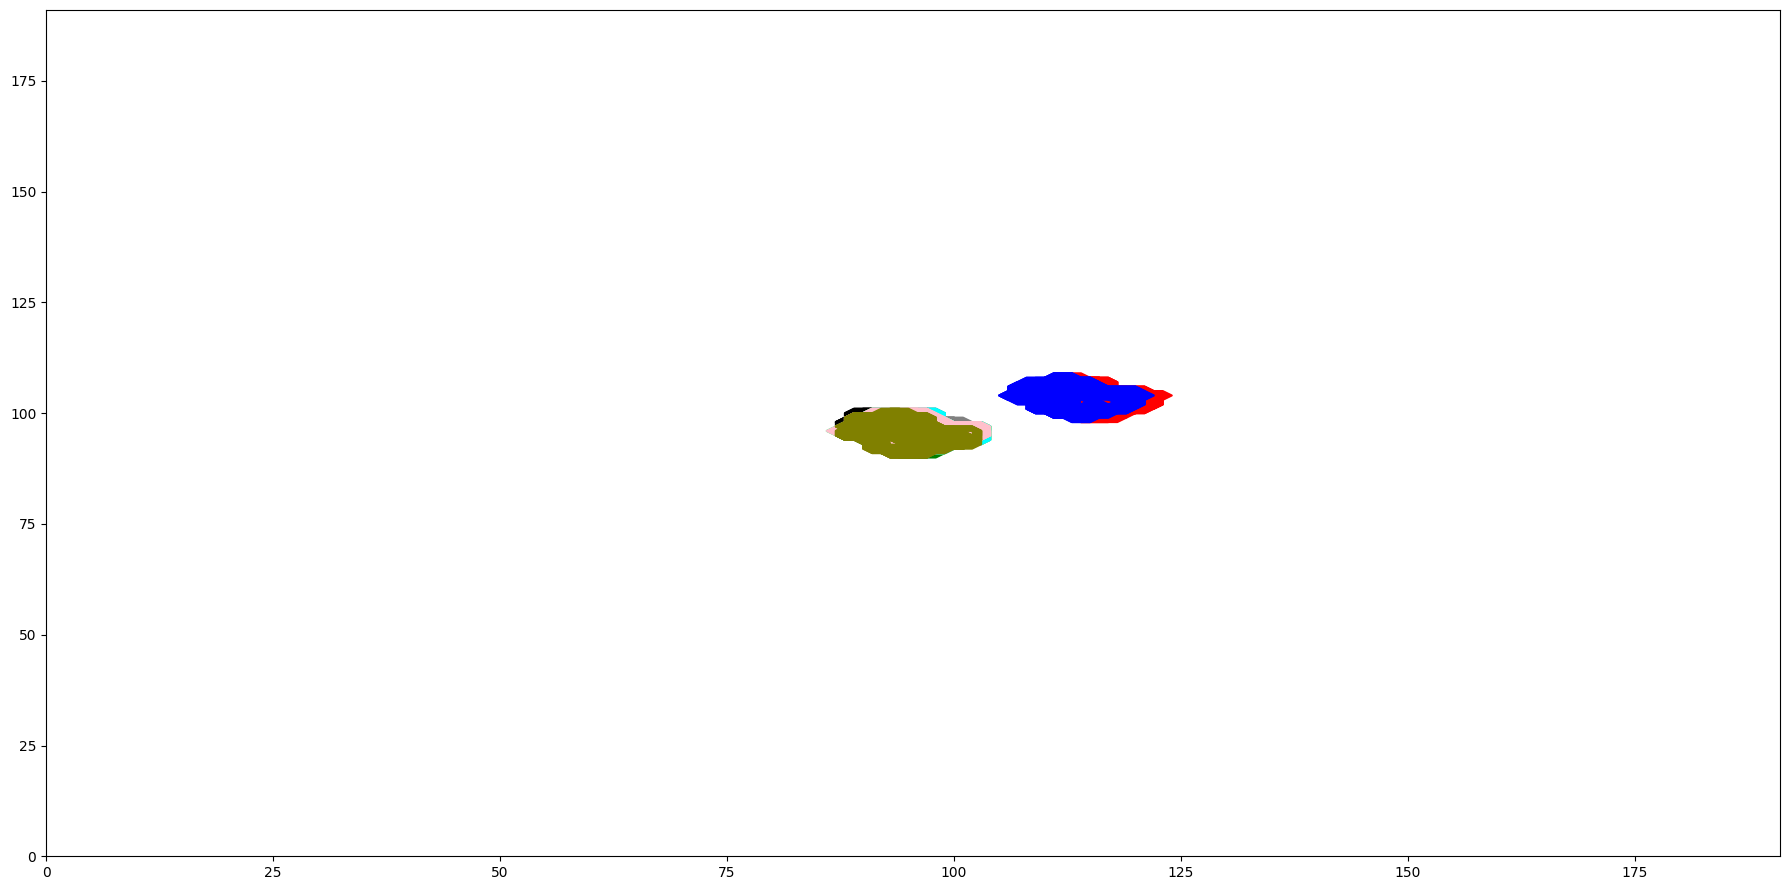

GTV # 0  -Centroid:  (100.71105826397147, 115.02378121284185, 87.63139120095124)
GTV # 1  -Centroid:  (100.12124849939975, 113.5798319327731, 87.47418967587035)
GTV # 2  -Centroid:  (95.86627906976744, 95.12790697674419, 95.61860465116278)
GTV # 3  -Centroid:  (95.93181818181819, 96.19772727272728, 94.82954545454545)
GTV # 4  -Centroid:  (96.09018264840182, 95.0068493150685, 94.80936073059361)
GTV # 5  -Centroid:  (96.30965593784684, 95.7746947835738, 94.89234184239734)
GTV # 6  -Centroid:  (96.05888767720829, 95.84078516902945, 94.99672846237732)
GTV # 7  -Centroid:  (96.47304730473047, 95.56325632563257, 94.98239823982398)
GTV # 8  -Centroid:  (96.04236343366779, 94.93199554069119, 95.76365663322186)


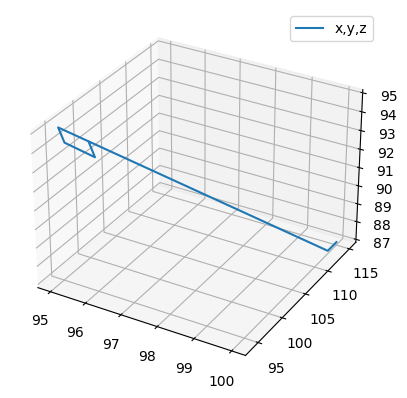

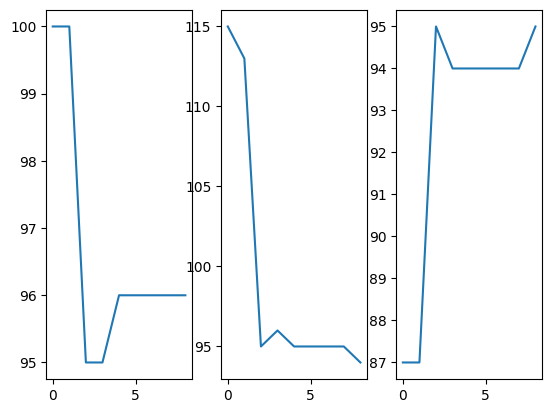

Limits:  5 21 8
2270307/
ct:  1 gtv 0 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
No GTV, will show ITV twice instead
CT val len: 9


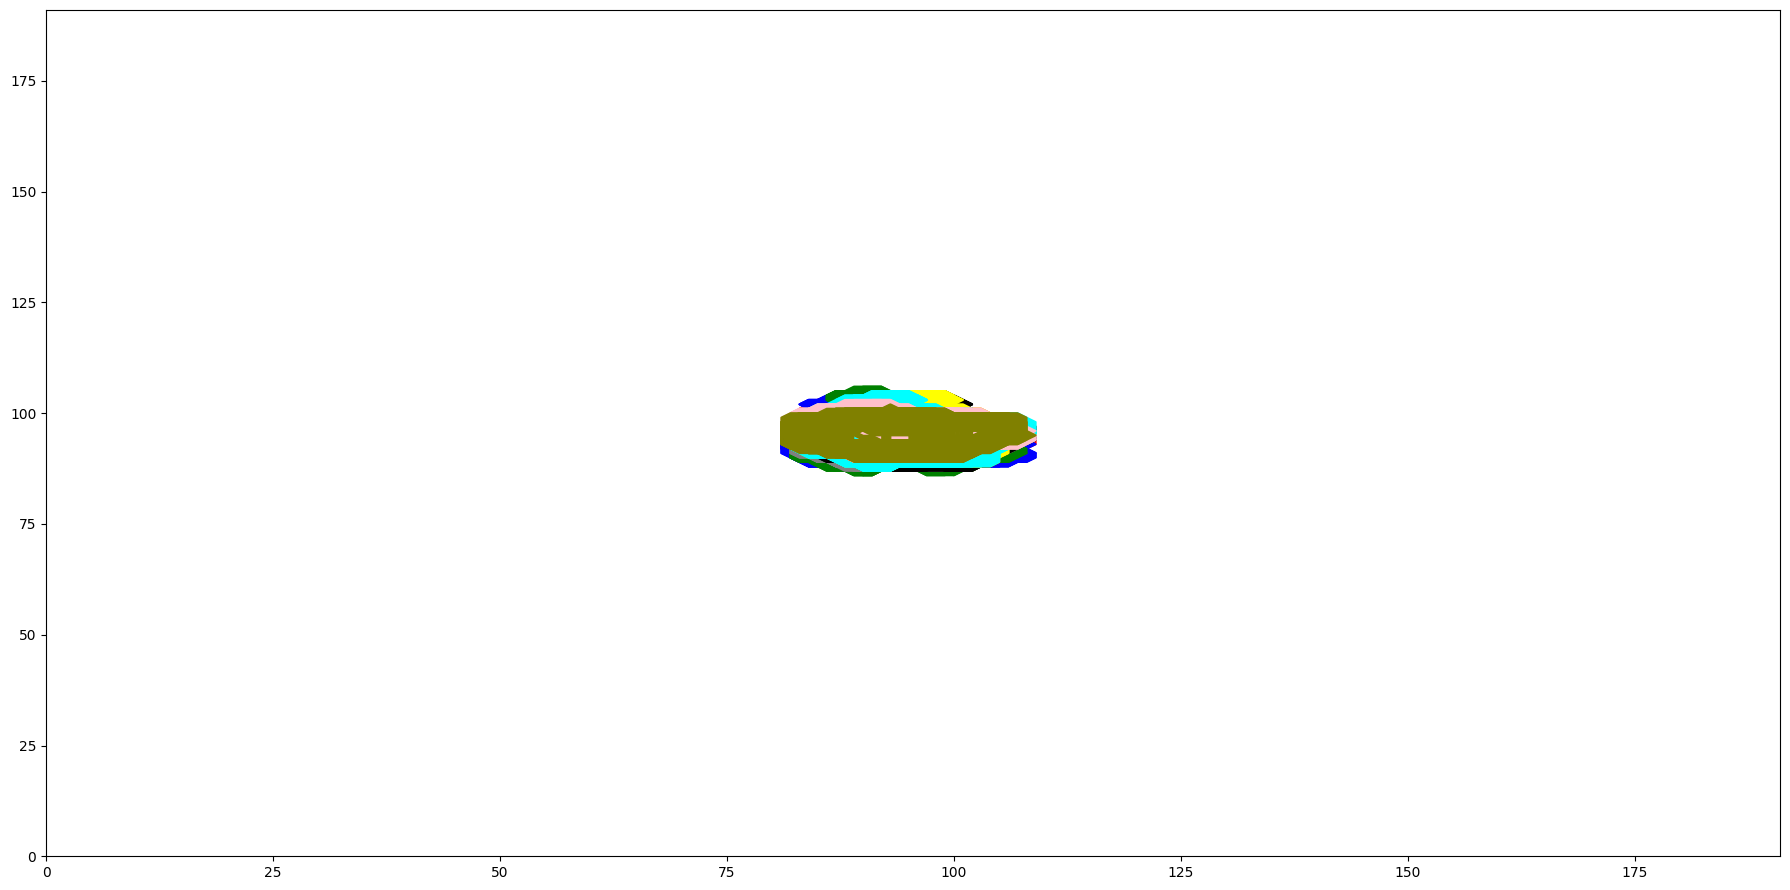

GTV # 0  -Centroid:  (95.20053039575683, 94.32109343125255, 95.9889840881273)
GTV # 1  -Centroid:  (96.74554325389379, 93.9260649277538, 96.61268530681178)
GTV # 2  -Centroid:  (96.35541752933057, 93.94847020933977, 96.85369220151829)
GTV # 3  -Centroid:  (96.29647000740557, 94.05603554677857, 96.8380646753888)
GTV # 4  -Centroid:  (96.08973517181002, 94.98971328518276, 96.07507113153864)
GTV # 5  -Centroid:  (95.42589737943185, 94.84981281656023, 95.81457828672099)
GTV # 6  -Centroid:  (96.16754701035285, 94.44918656243398, 95.75364462286076)
GTV # 7  -Centroid:  (95.42268281322777, 93.64904517931998, 95.28691197019097)
GTV # 8  -Centroid:  (94.96969696969697, 93.72165200391007, 95.48240469208211)


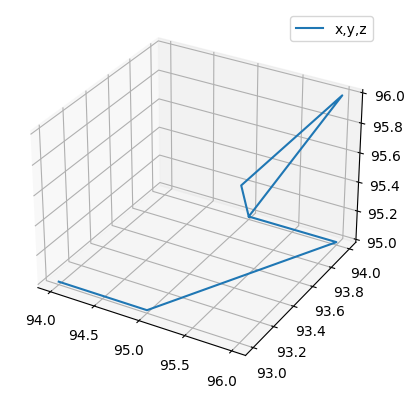

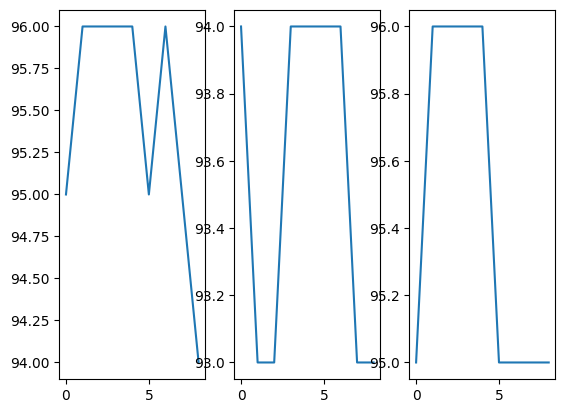

Limits:  2 1 1
6347891/
ct:  1 gtv 1 Lungs:  1 ITVLabel:  1 pITV no 1 Ave 1 GTV No 9
CT val len: 9


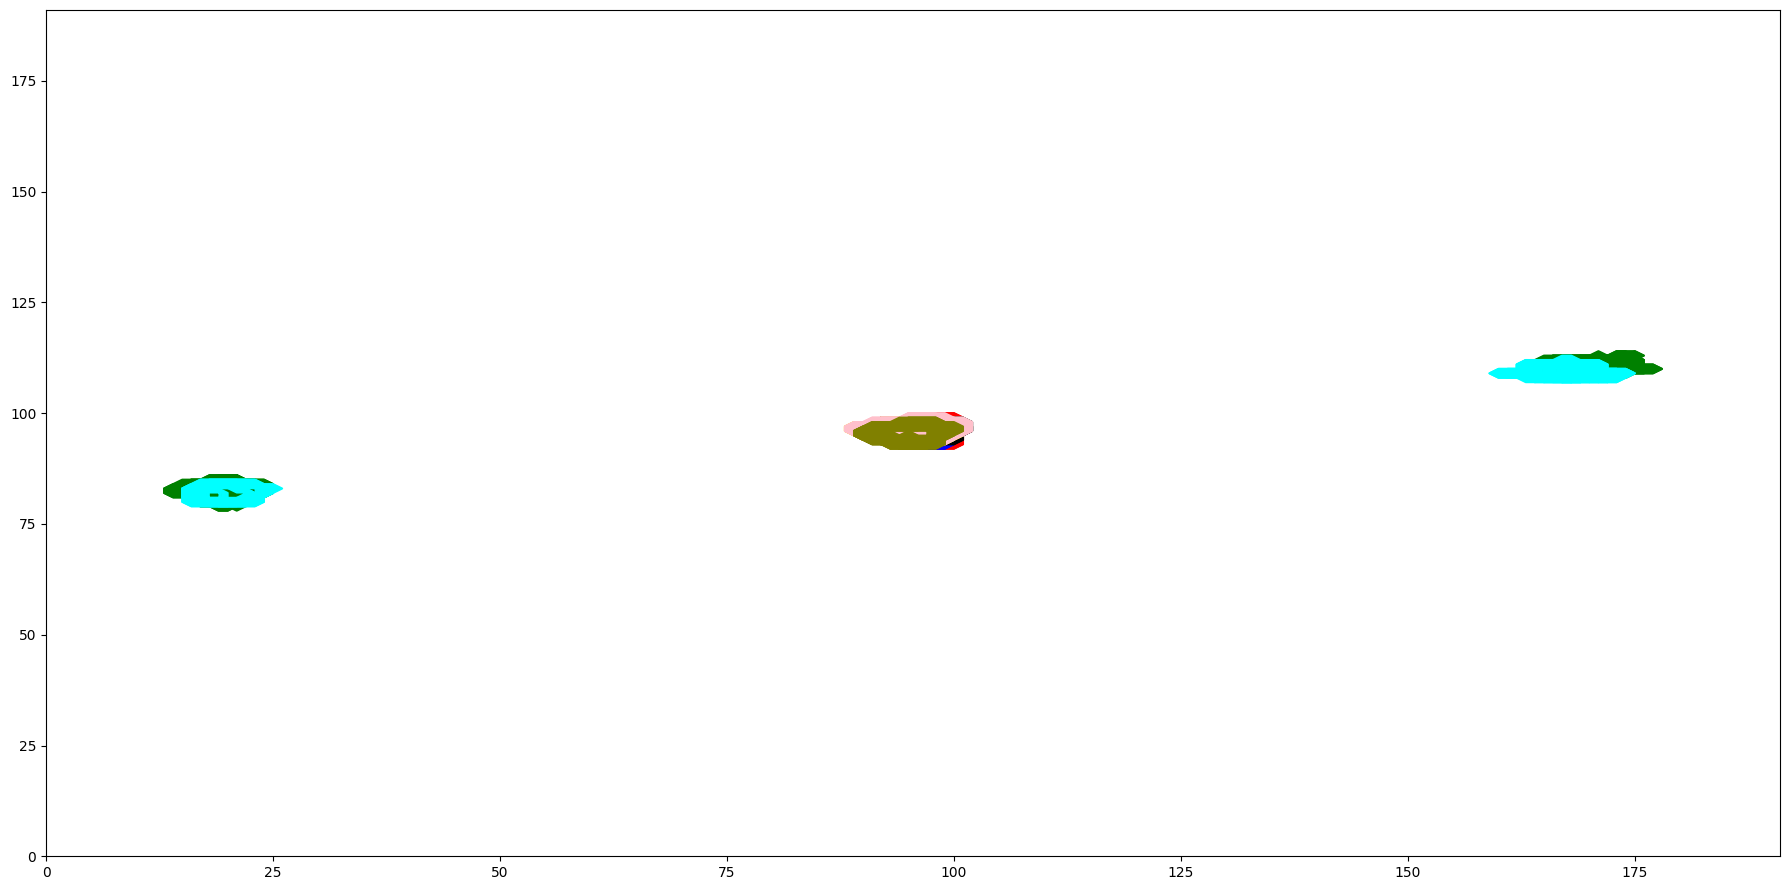

GTV # 0  -Centroid:  (95.17155756207674, 95.76523702031602, 95.15124153498871)
GTV # 1  -Centroid:  (94.17142857142858, 95.33714285714285, 95.41428571428571)
GTV # 2  -Centroid:  (94.52023121387283, 170.4335260115607, 80.3728323699422)
GTV # 3  -Centroid:  (94.00280112044818, 95.4873949579832, 95.10364145658264)
GTV # 4  -Centroid:  (95.6831955922865, 95.53994490358127, 94.94765840220386)
GTV # 5  -Centroid:  (95.37175792507205, 94.63400576368876, 95.18155619596541)
GTV # 6  -Centroid:  (95.36085626911316, 167.21406727828747, 81.5045871559633)
GTV # 7  -Centroid:  (95.46208530805687, 94.94549763033176, 94.95734597156398)
GTV # 8  -Centroid:  (95.4095238095238, 94.9047619047619, 95.64444444444445)


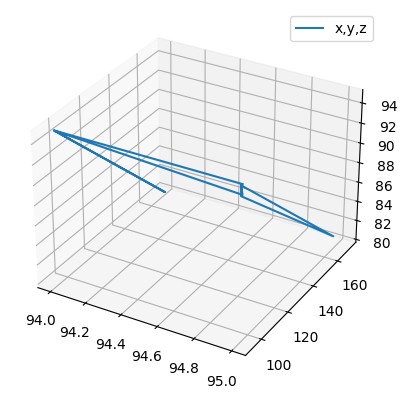

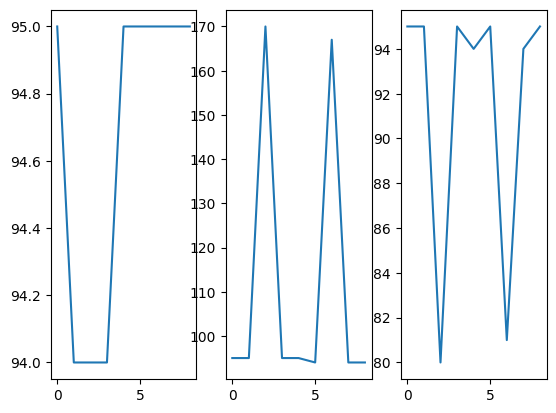

Limits:  1 76 15


In [41]:
##MAIN
limX = [] 
limY = [] 
limZ = [] 

pxL = ['4933165/','2038375/','8643781/','5655827/','5836741/','0070683/','1726691/','4660898/','2270307/','6347891/']

for px_ in pxL:
    all_patientdir = []
    all_patientdir.append(px_)
    #all_patientdir = os.listdir(root_path)
    all_patientdir.sort()
    CTALL_fpaths, itv_fpaths,gtv_fpaths, lungALL_fpaths,predicted_fpaths_no,gtvNofpaths = LookSortFiles(root_path, all_patientdir)

    #Create data dictionat
    data_dicts = [
        {"GTV_no":gtvNo_name}
        for gtvNo_name in zip(gtvNofpaths)
    ]
    val_files =data_dicts[:]
    print('CT val len:',len(val_files))

    val_inputs = LoadDataSet(val_files,val_transforms)
    plotContours(val_inputs)
    xx,yy,zz = TumorTrajectory(val_inputs)
    
    limX.append(xx)
    limY.append(yy)
    limZ.append(zz)

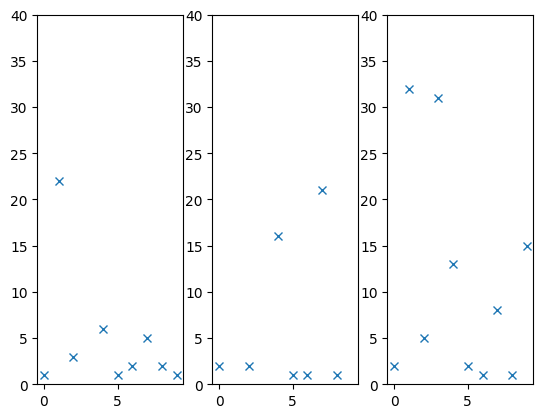

In [44]:
plt.subplot(1,3,1),plt.plot(limX,'x'),plt.ylim(0, 40)
plt.subplot(1,3,2),plt.plot(limY,'x'),plt.ylim(0, 40)
plt.subplot(1,3,3),plt.plot(limZ,'x'),plt.ylim(0, 40)
plt.show()